In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb2"
version = "b2"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb2 with 10 classes running on: cifar10
The input image size is:(260, 260)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 260, 260])
Datasets loaded and prepared


In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = math.ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*math.ceil(int(channels*width_factor) / 4)
            layers_repeats = math.ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(64,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.InvertedResidualBlock'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_l

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model requires: 3.2335 GFLOPS

torch.Size([64, 3, 260, 260])
torch.Size([64, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 35, 130, 130]             945
       BatchNorm2d-2         [-1, 35, 130, 130]              70
              SiLU-3         [-1, 35, 130, 130]               0
          CNNBlock-4         [-1, 35, 130, 130]               0
            Conv2d-5         [-1, 35, 130, 130]             315
       BatchNorm2d-6         [-1, 35, 130, 130]              70
              SiLU-7         [-1, 35, 130, 130]               0
          CNNBlock-8         [-1, 35, 130, 130]               0
 AdaptiveAvgPool2d-9             [-1, 35, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             288
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 35, 1, 1]             315
          Sigmoid

In [7]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [8]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb220211022000345
grandstore_string:
grandstore/cifar10_EfficientNetb220211022000345.pkl


In [9]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [10]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=120,
                    minepoch=30,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 42.880
Training Loss: 80517385.6508 	Validation Loss: 15803.7827

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 63.360
Training Loss: 55617522.6761 	Validation Loss: 10228.7659

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 72.320
Training Loss: 40560900.4486 	Validation Loss: 7908.3565

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 75.730
Training Loss: 32114802.8568 	Validation Loss: 6982.0804

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 79.240
Training Loss: 26697861.2878 	Validation Loss: 5950.2442

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 80.780
Training Loss: 22636809.7939 	Validation Loss: 5642.1440

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.020
Training Loss: 19581737.6917 	Validation Loss: 5139.9542

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.340
Training Loss: 16689822.2840 	Validation Loss: 4874.7474

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.700
Training Loss: 14672958.4785 	Validation Loss: 5139.6097

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.550
Training Loss: 12778413.4809 	Validation Loss: 5064.2952

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.960
Training Loss: 10651916.5560 	Validation Loss: 5066.6554

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.850
Training Loss: 8891409.7606 	Validation Loss: 5386.3523

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.440
Training Loss: 8007643.3093 	Validation Loss: 5321.0772

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.780
Training Loss: 6625404.9032 	Validation Loss: 5289.9148

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.190
Training Loss: 5992993.9224 	Validation Loss: 5898.1440

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.570
Training Loss: 5102781.9452 	Validation Loss: 6099.1978

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.850
Training Loss: 4763818.7176 	Validation Loss: 5849.7544

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.730
Training Loss: 4271764.5155 	Validation Loss: 5793.7468

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.920
Training Loss: 4030410.7497 	Validation Loss: 6049.8598

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.610
Training Loss: 3771400.3822 	Validation Loss: 6385.4591

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.270
Training Loss: 3413456.7386 	Validation Loss: 6055.0535

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.480
Training Loss: 3408241.3165 	Validation Loss: 6389.8101

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.060
Training Loss: 3067993.7892 	Validation Loss: 6429.5537

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.120
Training Loss: 3092316.6268 	Validation Loss: 7158.2409

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.930
Training Loss: 2989343.2986 	Validation Loss: 7051.5754

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.990
Training Loss: 2726082.2956 	Validation Loss: 6523.1953

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.320
Training Loss: 2527079.1428 	Validation Loss: 7031.0444

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 2377327.9540 	Validation Loss: 6625.4958

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.790
Training Loss: 2338071.1536 	Validation Loss: 7022.3688

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.960
Training Loss: 2359667.4184 	Validation Loss: 6978.5336

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.890
Training Loss: 2361897.8163 	Validation Loss: 6991.8550

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.930
Training Loss: 2115069.2914 	Validation Loss: 6833.2190

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.530
Training Loss: 2067651.1823 	Validation Loss: 7121.6104

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 1953187.2900 	Validation Loss: 6980.8269

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.560
Training Loss: 2052070.3165 	Validation Loss: 7257.6979

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 1945616.5564 	Validation Loss: 6933.4396

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.030
Training Loss: 1692583.4585 	Validation Loss: 7198.5524

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.220
Training Loss: 1817650.7928 	Validation Loss: 7538.1074

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 1826092.4966 	Validation Loss: 7044.3235

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.580
Training Loss: 1885133.2042 	Validation Loss: 6891.8114

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.100
Training Loss: 1553622.2361 	Validation Loss: 7551.5305

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 1571176.1590 	Validation Loss: 7349.3297

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.910
Training Loss: 1690488.0192 	Validation Loss: 7354.1648

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.060
Training Loss: 1638874.5270 	Validation Loss: 7499.2504

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.930
Training Loss: 1494784.3987 	Validation Loss: 7131.2610

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.670
Training Loss: 1309455.4075 	Validation Loss: 7920.5007

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 1420196.3041 	Validation Loss: 7580.7362

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.470
Training Loss: 1420402.9695 	Validation Loss: 7508.7815

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.490
Training Loss: 1433536.2323 	Validation Loss: 7668.0833

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.910
Training Loss: 1364796.3919 	Validation Loss: 7251.1812

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 1427727.6552 	Validation Loss: 7566.2561

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.510
Training Loss: 1158243.9582 	Validation Loss: 7810.4216

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.650
Training Loss: 1318180.7730 	Validation Loss: 7234.6242

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.920
Training Loss: 1335583.6070 	Validation Loss: 7394.5016

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 1220820.3282 	Validation Loss: 7539.8960

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 1169295.3130 	Validation Loss: 7654.8313

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 1259626.4556 	Validation Loss: 7610.7896

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1351369.0977 	Validation Loss: 7792.2682

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 1162537.4871 	Validation Loss: 7377.1535

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 1046083.6363 	Validation Loss: 7720.0673

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 1215674.2669 	Validation Loss: 7576.1444

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 946421.2991 	Validation Loss: 7916.5617

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 1221881.7698 	Validation Loss: 7913.9616

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 1034646.2923 	Validation Loss: 7856.2529

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 1042817.0481 	Validation Loss: 7944.1527

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 1135784.6766 	Validation Loss: 8166.5405

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 1068823.0495 	Validation Loss: 7801.1791

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.590
Training Loss: 885226.7709 	Validation Loss: 8035.0692

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 1055637.3789 	Validation Loss: 7687.5487

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.470
Training Loss: 1011664.8943 	Validation Loss: 7953.3529

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 915723.9997 	Validation Loss: 7840.7710

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 1002236.5678 	Validation Loss: 7988.3768

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 938851.6164 	Validation Loss: 7344.4057

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 785656.2088 	Validation Loss: 7893.3234

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 894826.3614 	Validation Loss: 8041.8212

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 820930.4954 	Validation Loss: 8249.6656

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 871696.8260 	Validation Loss: 8498.6119

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 1003138.2103 	Validation Loss: 7564.0534

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 795286.8028 	Validation Loss: 8926.8786

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.500
Training Loss: 897616.2798 	Validation Loss: 8269.1659

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.730
Training Loss: 974178.9992 	Validation Loss: 8306.6685

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.430
Training Loss: 1003712.0299 	Validation Loss: 8561.7303

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 698568.5218 	Validation Loss: 8382.4480

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.350
Training Loss: 735028.3660 	Validation Loss: 8550.7947

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 946564.3054 	Validation Loss: 8123.9540

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 782118.8812 	Validation Loss: 8356.8509

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 847904.4054 	Validation Loss: 8527.0635

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.740
Training Loss: 739599.6193 	Validation Loss: 8630.0672

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 792140.0500 	Validation Loss: 8826.2765

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 841161.1896 	Validation Loss: 8351.4541

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 867340.3181 	Validation Loss: 8358.9620

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.210
Training Loss: 653679.3128 	Validation Loss: 8858.7297

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 888909.8699 	Validation Loss: 8547.2896

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 703565.1721 	Validation Loss: 8791.2327

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 817975.8442 	Validation Loss: 8816.4067

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 743521.2298 	Validation Loss: 8311.3448

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 728804.2720 	Validation Loss: 9367.7218

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 667634.9920 	Validation Loss: 8351.1226

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 599896.0589 	Validation Loss: 8653.9835

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 805201.3880 	Validation Loss: 8298.9588

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 720042.1057 	Validation Loss: 7939.7056

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 675580.8833 	Validation Loss: 8632.9155

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.480
Training Loss: 678957.7434 	Validation Loss: 8748.3986

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 651578.3288 	Validation Loss: 8558.4525

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.190
Training Loss: 599678.1886 	Validation Loss: 9359.7964

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 839331.9130 	Validation Loss: 8676.7538

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 631025.7187 	Validation Loss: 9076.4927

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 704189.4226 	Validation Loss: 9347.1557

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 694856.7061 	Validation Loss: 8767.7705

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 737949.4948 	Validation Loss: 8762.1716

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.530
Training Loss: 761507.2439 	Validation Loss: 8935.5058

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.540
Training Loss: 630611.3872 	Validation Loss: 9500.1617

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 746340.3737 	Validation Loss: 8690.0204

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 538318.3235 	Validation Loss: 8669.4576

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.990
Training Loss: 657461.4855 	Validation Loss: 8866.2127

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 704000.8431 	Validation Loss: 8866.8434

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 677220.2637 	Validation Loss: 8731.2658

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.730
Training Loss: 588342.3487 	Validation Loss: 8809.7050

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 597635.2579 	Validation Loss: 9037.0923

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 646402.1661 	Validation Loss: 8705.2104



Total Run 120 epoch(s)
Accuracy MIN: 42.88 / MAX: 86.65

Top 5 performing epochs:
#1 epoch 78	||train_acc 86.65%	||test 86.38%
#2 epoch 102	||train_acc 86.53%	||test 85.84%
#3 epoch 104	||train_acc 86.5%	||test 86.22%
#4 epoch 59	||train_acc 86.45%	||test 85.98%
#5 epoch 100	||train_acc 86.36%	||test 85.96%

Last epoch:
epoch 120	||train_acc 86.1%	||test 85.96%

The model has parameters: 29487358


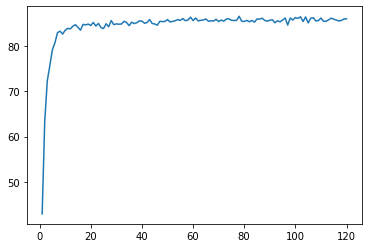

In [11]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [13]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb220211022000345.pkl
